In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

!pip install /content/pandas-1.3.5-cp311-cp311-linux_x86_64.whl
!pip install /content/torch_geometric_temporal-0.54.0-py3-none-any.whl

!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install momepy

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.7 MB/s eta 0:00:00
Processing ./pandas-1.3.5-cp311-cp311-linux_x86_64.whl
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.3.5 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 1.3.5 which is inco

In [2]:
!pip install torch_geometric==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: torch_geometric
    Found existing installation: torch-geometric 2.7.0
    Uninstalling torch-geometric-2.7.0:
      Successfully uninstalled torch-geometric-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-geometric-temporal 0.54.0 requires pandas<=1.3.5, but you have pandas 2.2.3 which is incompatible.


In [3]:
import pandas as pd
pd.options.mode.copy_on_write = True
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic as GD
from shapely.geometry import Point, LineString
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
from torch_geometric_temporal.nn.recurrent import A3TGCN, A3TGCN2

In [4]:
from static_paths import *
from utils import load_file, save_file, get_device
from data_utils import zscore, inverse_zscore, smooth_data, find_nearest_node
from data_preprocess import load_road_data

Already processed sensor data

Road Distance calculation with road network graph

# Vilnius roads visualization with sensor locations

In [ ]:
import contextily as ctx

In [ ]:
gdf_roads_web_mercator = roads.to_crs(epsg=3857)
gdf_sensors_web_mercator = gdf_sensors.to_crs(epsg=3857)

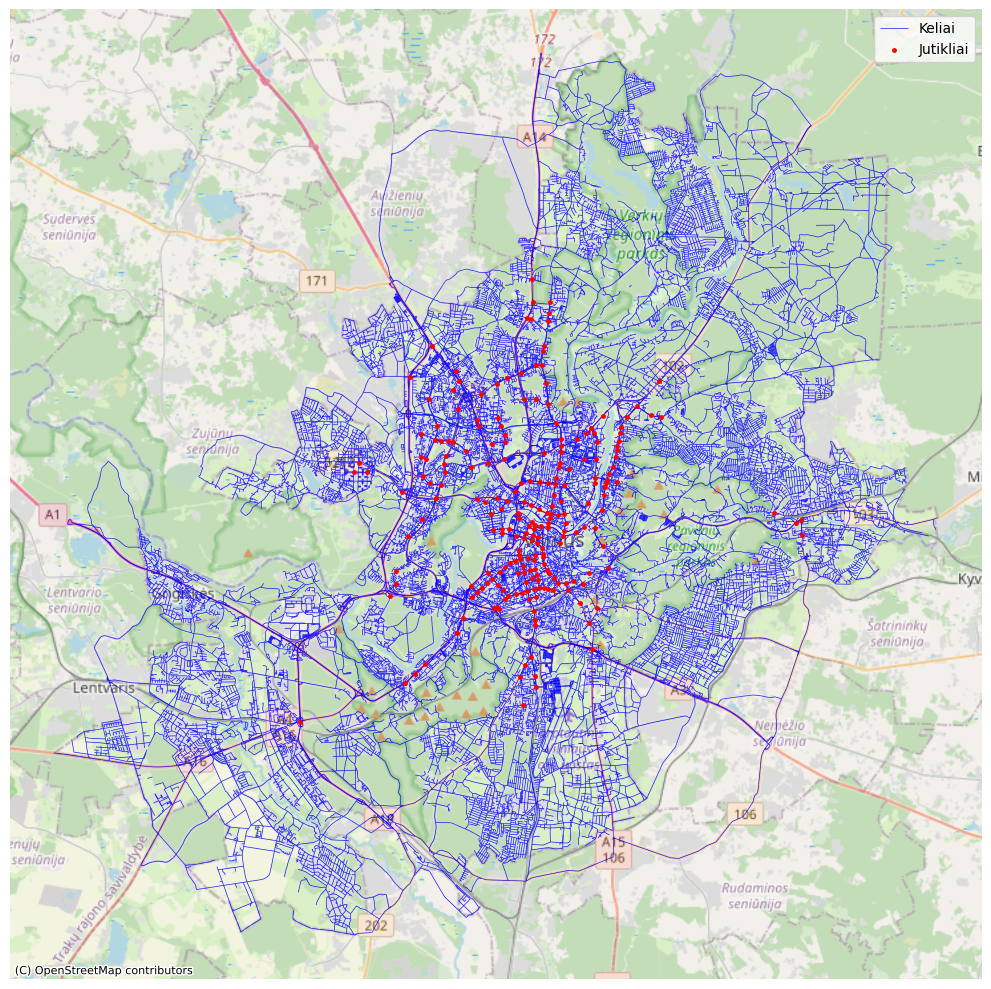

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf_roads_web_mercator.plot(ax=ax, color='blue', edgecolor='black', linewidth=0.5, label='Keliai', alpha=0.9, zorder=2)
gdf_sensors_web_mercator.plot(ax=ax, color='red', marker='.', markersize=25, label='Jutikliai', alpha=1, zorder=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom='auto', alpha=0.9)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels, zoom='auto', alpha=0.9)
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterOnlyLabels, zoom='auto', alpha=0.9)
# ax.set_title('Map of Vilnius Roads and Traffic Sensors', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.axis('off')
#ax.grid(True) # Add a grid for better readability
ax.set_aspect('equal')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
np.savetxt("distance_matrix_roads.csv", distance_matrix, delimiter=",")

In [ ]:
# import statsmodels.api as sm

In [ ]:
# # Detrend each sensor's speed data (subtract linear trend)
# residuals = np.zeros_like(sensor_data_matrix)
# for sensor in range(sensor_data_matrix.shape[1]):
#     X = sm.add_constant(np.arange(8758))  # Hours as predictor
#     model = sm.OLS(sensor_data_matrix[:, sensor], X).fit()
#     residuals[:, sensor] = model.resid  # Store residuals

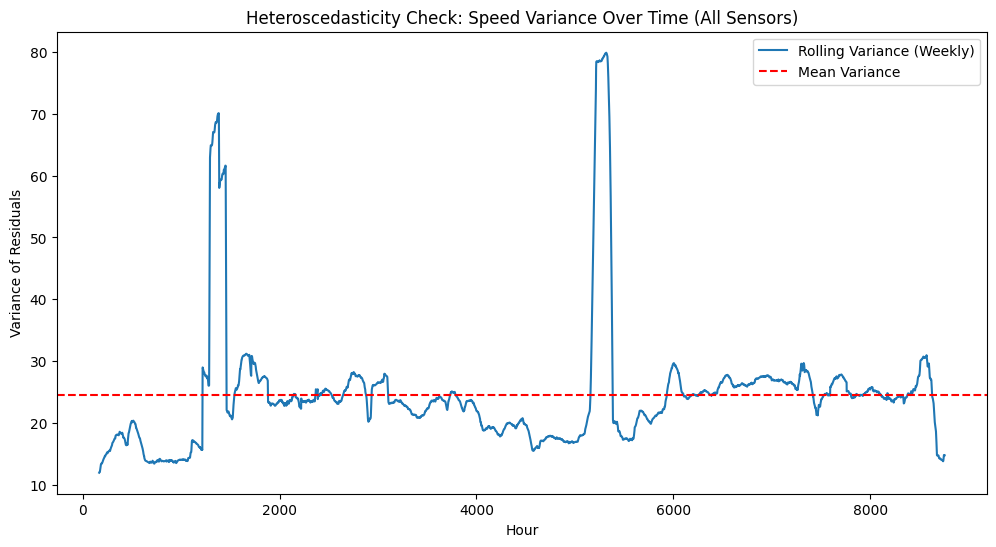

In [ ]:
# window_size = 24 * 7  # Weekly window (168 hours)
# rolling_var = pd.DataFrame(residuals).rolling(window_size).var().mean(axis=1)  # Mean variance across sensors

# plt.figure(figsize=(12, 6))
# plt.plot(rolling_var, label='Rolling Variance (Weekly)')
# plt.xlabel("Hour")
# plt.ylabel("Variance of Residuals")
# plt.title("Heteroscedasticity Check: Speed Variance Over Time (All Sensors)")
# plt.axhline(y=rolling_var.mean(), color='r', linestyle='--', label='Mean Variance')
# plt.legend()
# plt.show()

# Load preprocessed data

In [5]:
sensor_data_matrix = load_file('/content/sensor_data_matrix.pkl')
sensor_distance_matrix = load_file('/content/sensor_distance_matrix.pkl')

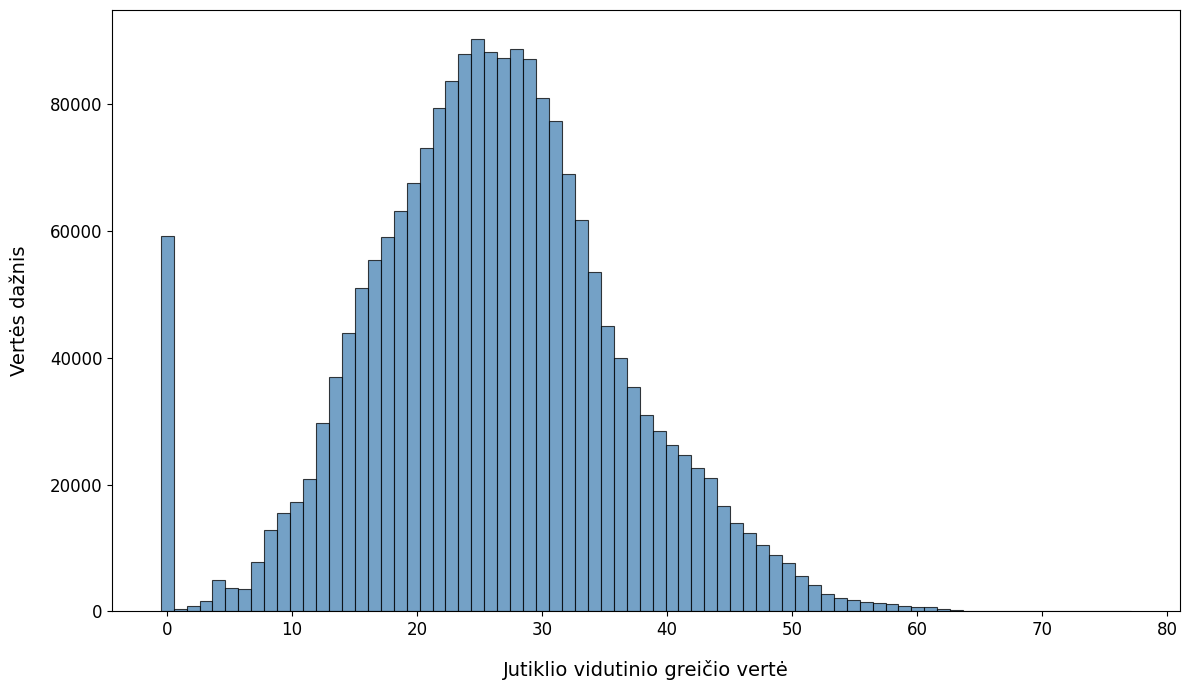

Used 75 bins for the histogram.


In [7]:
from scipy.stats import iqr

sensor_data_matrix = np.nan_to_num(sensor_data_matrix, nan=0)
data_for_plotting = sensor_data_matrix.flatten()

if len(data_for_plotting) > 1 and np.ptp(data_for_plotting) > 0: # ptp checks if (max-min) > 0
    current_iqr = iqr(data_for_plotting)
    if current_iqr > 0:
        bin_width = 2 * current_iqr / (len(data_for_plotting) ** (1/3))
        if bin_width > 0:
            num_bins = int((np.max(data_for_plotting) - np.min(data_for_plotting)) / bin_width)
        else: # Fallback if bin_width is zero (e.g. current_iqr is tiny)
            num_bins = 30
    else: # Fallback if IQR is 0 (e.g., many identical values, little variability)
        # Sturges' rule as a fallback for number of bins
        num_bins = int(1 + np.log2(len(data_for_plotting))) if len(data_for_plotting) > 1 else 10

    # Cap the number of bins to prevent an overly "choppy" look and ensure a minimum
    num_bins = max(10, min(num_bins, 75)) # Adjusted cap for typical "pretty" look
else:
    print("Data has insufficient variability or size to determine bins. Defaulting to 20 bins.")
    num_bins = 20

plt.style.use('default') # Apply a nicer style

plt.figure(figsize=(12, 7)) # Adjusted figure size for better readability

plt.hist(data_for_plotting,
         bins=num_bins,
         color='steelblue', # A pleasant, common blue
         alpha=0.75,        # Slight transparency
         edgecolor='black', # Adds definition to bins, making it less "choppy"
         linewidth=0.8)     # Line width for bin edges

# Optional: Add a Kernel Density Estimate (KDE) for a smoother distribution outline
# Requires seaborn: import seaborn as sns
# sns.kdeplot(data_for_plotting, color='darkred', linewidth=2, label='KDE', fill=True, alpha=0.1)

# 4. Add labels and title
# plt.title('Distribution of Sensor Data Values', fontsize=16, pad=20)
plt.xlabel('Jutiklio vidutinio greičio vertė', fontsize=14, labelpad=15)
plt.ylabel('Vertės dažnis', fontsize=14, labelpad=15)

# Customize ticks for a cleaner look
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Add a legend if you included the KDE plot
# if any(isinstance(line, plt.Line2D) for line in plt.gca().lines): # Check if KDE plotted
#     plt.legend(fontsize=12)

plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping
plt.show()

print(f"Used {num_bins} bins for the histogram.")

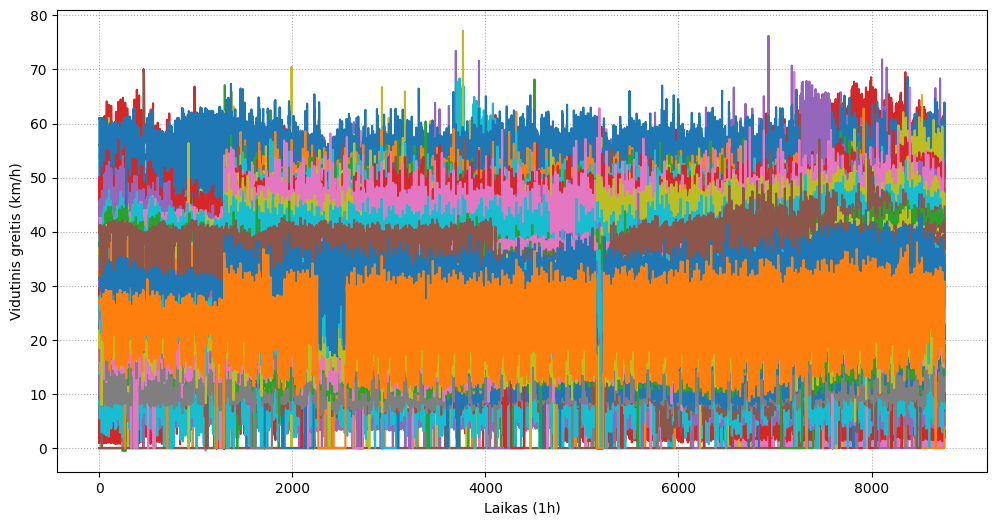

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(sensor_data_matrix)
plt.grid(linestyle=':')
plt.xlabel('Laikas (1h)')
plt.ylabel('Vidutinis greitis (km/h)')
#plt.title('2018 metų laiko eilutė')
plt.show()

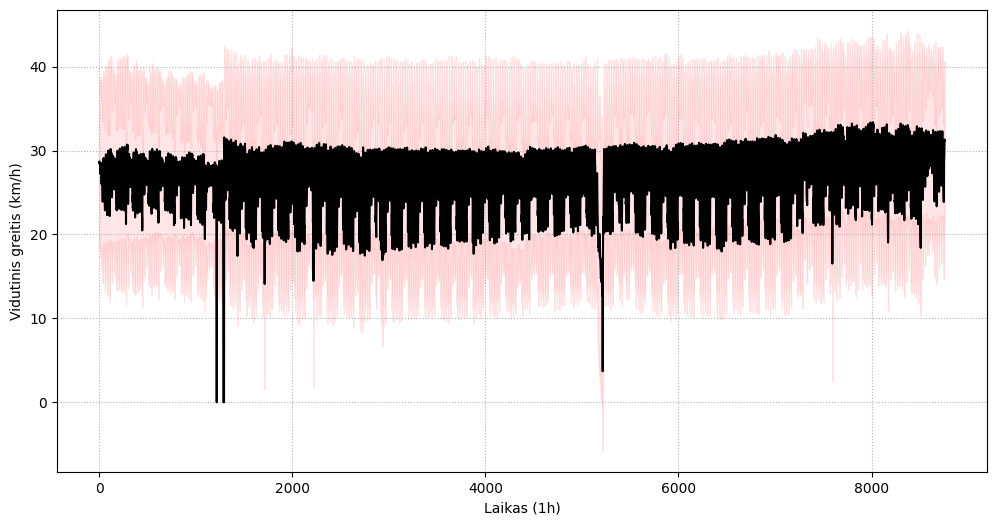

In [ ]:
sensor_data_matrix = np.nan_to_num(sensor_data_matrix, nan=0)
mean_speeds = sensor_data_matrix.mean(axis=1)
std = sensor_data_matrix.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(mean_speeds, 'k-')
plt.fill_between(np.arange(sensor_data_matrix.shape[0]), mean_speeds - std, mean_speeds + std, color='r', alpha=0.1)
plt.grid(linestyle=':')
plt.xlabel('Laikas (1h)')
plt.ylabel('Vidutinis greitis (km/h)')
plt.show()

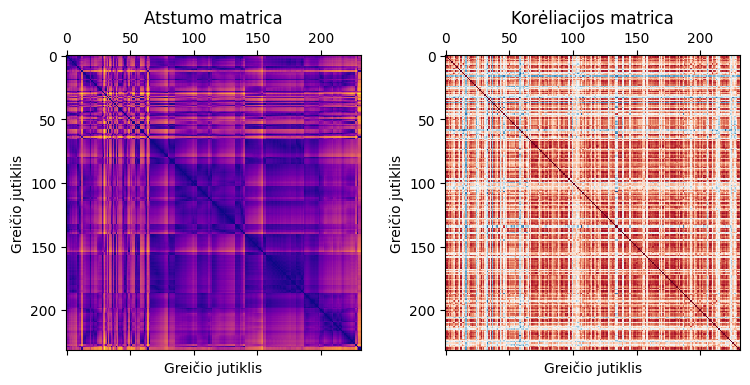

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(sensor_distance_matrix, cmap = 'plasma')
ax1.set_xlabel('Greičio jutiklis')
ax1.set_ylabel('Greičio jutiklis')
ax1.title.set_text('Atstumo matrica')
ax2.matshow(-np.corrcoef(sensor_data_matrix.T), cmap='RdBu')
ax2.set_xlabel('Greičio jutiklis')
ax2.set_ylabel('Greičio jutiklis')
ax2.title.set_text('Korėliacijos matrica')

<Figure size 800x800 with 0 Axes>

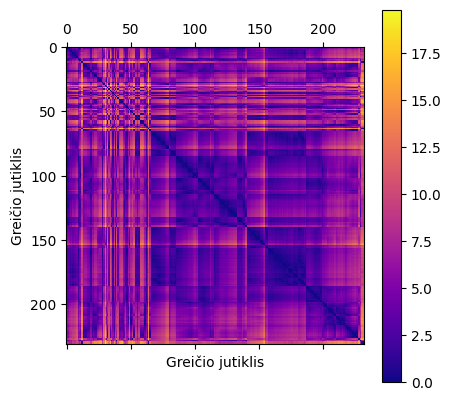

In [ ]:
plt.figure(figsize=(8, 8))
ax1 = plt.matshow(sensor_distance_matrix, cmap = 'plasma')
plt.colorbar(ax1)
plt.xlabel('Greičio jutiklis')
plt.ylabel('Greičio jutiklis')
plt.show()

<Figure size 800x800 with 0 Axes>

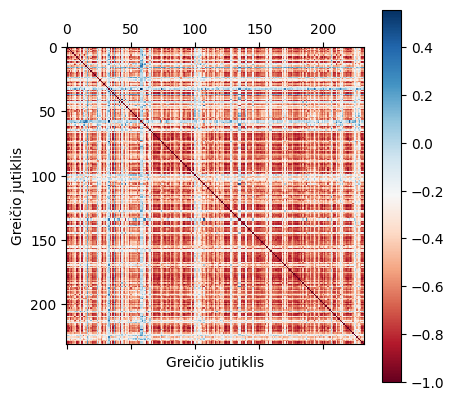

In [ ]:
plt.figure(figsize=(8, 8))
ax2 = plt.matshow(-np.corrcoef(sensor_data_matrix.T), cmap='RdBu')
plt.colorbar(ax2)
plt.xlabel('Greičio jutiklis')
plt.ylabel('Greičio jutiklis')
plt.show()

In [16]:
from adjacency_matrices import compute_interpolation_adjacency_matrix

In [17]:
adjacency_matrix = compute_interpolation_adjacency_matrix(sensor_distance_matrix)

Text(0, 0.5, 'Sensor station')

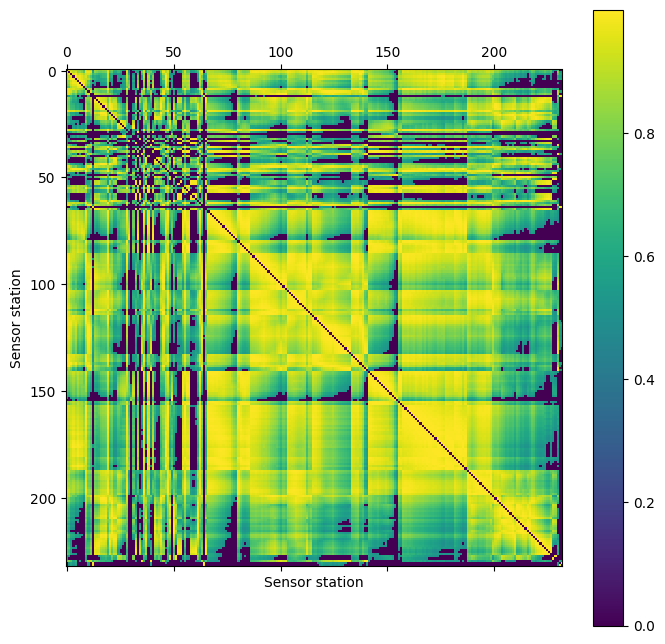

In [ ]:
plt.figure(figsize=(8, 8))
cax = plt.matshow(adjacency_matrix, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

dataloader

In [10]:
device = get_device()

In [14]:
from data_preparation import prepare_edge_index_and_attributes, prepare_predictions_dataset, prepare_prediction_dataloader

In [18]:
edge_index, edge_attr = prepare_edge_index_and_attributes(adjacency_matrix, device)

In [19]:
normalized_sensor_data = zscore(sensor_data_matrix, sensor_data_matrix.mean(), sensor_data_matrix.std())

In [ ]:
# smoothed_sensor_data = pd.DataFrame(normalized_sensor_data).ewm(span=5, adjust=False).mean().to_numpy()

In [87]:
# Dataset
sequence_len = 24
prediction_len = 1

X_train, Y_train, X_test, Y_test = prepare_predictions_dataset(
    normalized_sensor_data,
    train_split=0.8,
    sequence_len=sequence_len,
    prediction_len=prediction_len
    )

In [88]:
#Dataloader

batch_size = 32
train_loader, test_loader = prepare_prediction_dataloader(
    X_train, Y_train, X_test, Y_test,
    device=device,
    batch_size=batch_size
)

In [89]:
def prepare_edge_weights(adjacency_matrix, device):
    """Extract edge weights from adjacency matrix"""
    edges = np.nonzero(adjacency_matrix)
    edge_weights = adjacency_matrix[edges]
    edge_weights = torch.from_numpy(edge_weights).type(torch.float).to(device)
    return edge_weights

In [90]:
import torch.nn as nn

In [91]:
edge_weights = prepare_edge_weights(adjacency_matrix, device)

In [100]:
class A3TGCNInterpolationModel(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, mask_ratio=0.2):
        super(A3TGCNInterpolationModel, self).__init__()

        self.mask_ratio = mask_ratio
        self.tgnn = A3TGCN2(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           batch_size=batch_size)

        self.speed_prediction_layer = nn.Linear(32, periods)

    def create_random_mask(self, x):
        mask = torch.ones_like(x, device=x.device)
        if x.shape[1] == 0: return mask
        num_nodes_to_mask = int(x.shape[1] * self.mask_ratio)
        if num_nodes_to_mask > 0:
            for i in range(x.shape[0]):
                k = min(num_nodes_to_mask, x.shape[1])
                indices_to_mask = torch.randperm(x.shape[1], device=x.device)[:k]
                mask[i, indices_to_mask, :] = 0
        return mask

    def create_full_network_mask(self, x_input_tensor, current_sensor_indices_tensor):
        """
        Creates a mask where only sensor locations have their features unmasked.
        x_input_tensor shape: e.g. [batch_size, num_nodes, features_dim, input_timesteps]
        """
        mask = torch.zeros_like(x_input_tensor, device=x_input_tensor.device)
        if current_sensor_indices_tensor is not None and current_sensor_indices_tensor.numel() > 0:
            valid_indices = current_sensor_indices_tensor[current_sensor_indices_tensor < x_input_tensor.shape[1]]
            if valid_indices.numel() > 0:
                # Apply to all feature/time dimensions for the selected sensor nodes
                if x_input_tensor.dim() == 3: # [B, N, F_agg]
                    mask[:, valid_indices, :] = 1
                elif x_input_tensor.dim() == 4: # [B, N, F, T_in]
                    mask[:, valid_indices, :, :] = 1
                else: # Fallback
                    mask[:, valid_indices] = 1
            elif current_sensor_indices_tensor.numel() > 0 :
                 print(f"Warning: Some sensor_indices were out of bounds for num_nodes={x_input_tensor.shape[1]}")
        return mask


    def forward(self, x, edge_index, edge_weight=None, sensor_indices=None, is_full_network=False):
        if is_full_network: input_mask = self.create_full_network_mask(x, sensor_indices)
        else: input_mask = self.create_random_mask(x)
        masked_x = x * input_mask

        h = self.tgnn(masked_x, edge_index, edge_weight)
        h_activated = F.relu(h)
        predicted_speeds = self.speed_prediction_layer(h_activated)
        return predicted_speeds, input_mask # Return intermediate for debugging

In [93]:
# Model

node_features = 1
periods = prediction_len
learning_rate = 0.0001
weight_decay_value = 0.001

model = A3TGCNInterpolationModel(node_features, periods, batch_size, 0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_value)

In [94]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [84]:
def train_model(model, optimizer, train_loader,
                           edge_index, edge_weight=None,
                           loss_fn=nn.SmoothL1Loss(reduction='none'),
                           epoch_count=25,
                           lr_scheduler_factor=0.1,    # For ReduceLROnPlateau
                           lr_scheduler_patience=10,   # For ReduceLROnPlateau
                           lr_scheduler_min_lr=1e-6,   # For ReduceLROnPlateau
                           lr_scheduler_verbose=True,  # For ReduceLROnPlateau
                           clip_grad_norm=1.0):
    """
    Trains a regression model (e.g., A3TGCNRegressionModel) for imputation,
    with learning rate scheduling and robust loss.
    Weight decay should be configured in the optimizer *before* passing it to this function.

    Args:
        model: The PyTorch regression model.
        optimizer: The PyTorch optimizer (e.g., Adam with weight_decay configured).
        train_loader: DataLoader for the training set (x_batch, y_batch).
        edge_index: Graph edge indices.
        edge_weight: Graph edge weights (optional).
        loss_fn: The regression loss function. Must have reduction='none' if used with
                 this function's masking logic. Defaults to SmoothL1Loss(reduction='none').
        epoch_count: Number of epochs to train for.
    """

    train_losses = []
    learning_rates = []
    scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                  factor=lr_scheduler_factor,
                                  patience=lr_scheduler_patience,
                                  min_lr=lr_scheduler_min_lr,
                                  verbose=lr_scheduler_verbose)

    edge_index = edge_index.to(device)
    if edge_weight is not None:
        edge_weight = edge_weight.to(device)
    model.to(device)

    for epoch in range(epoch_count):
        model.train()
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{epoch_count} | Learning Rate: {current_lr:.2e}\n-------------------------------')

        batch_losses = []
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            predicted_speeds, input_mask_values = model(x_batch, edge_index, edge_weight)

            # Create y_mask_for_loss: 1 where input x was masked for the node
            # Assumes input_mask_values has shape [B, N, F_in, T_in] or similar [B, N, ...]
            # and y_batch has shape [B, N, T_out]
            if input_mask_values.numel() == 0: # Should not happen if x_batch is not empty
                node_was_input_masked = torch.zeros(x_batch.shape[0], x_batch.shape[1], device=device, dtype=torch.bool)
            else:
                # Check if any feature/timestep for a node was masked in the input
                # Reduce along all dimensions except batch and node (dims 0 and 1)
                dims_to_reduce_in_mask = tuple(range(2, input_mask_values.dim()))
                if dims_to_reduce_in_mask:
                    node_was_input_masked = torch.any(input_mask_values == 0, dim=dims_to_reduce_in_mask)
                else: # input_mask_values is already [B,N]
                    node_was_input_masked = (input_mask_values == 0)

            # Expand to match y_batch's shape [B, N, T_out]
            y_mask_for_loss = node_was_input_masked.unsqueeze(-1).expand_as(y_batch).float()

            elementwise_loss = loss_fn(predicted_speeds, y_batch) # Requires loss_fn with reduction='none'
            masked_loss_elements = elementwise_loss * y_mask_for_loss
            num_valid_elements = torch.sum(y_mask_for_loss) + 1e-8 # Avoid division by zero

            loss = torch.sum(masked_loss_elements) / num_valid_elements if num_valid_elements > 1e-7 else torch.tensor(0.0, device=device, requires_grad=True)

            optimizer.zero_grad()
            if loss.requires_grad:
                 loss.backward()

            if clip_grad_norm is not None and clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)

            optimizer.step()
            batch_losses.append(loss.item())

        mean_epoch_loss = sum(batch_losses) / len(batch_losses) if batch_losses else 0.0
        print(f"Train Regression Loss: {mean_epoch_loss:.4f}\n")
        train_losses.append(mean_epoch_loss)
        learning_rates.append(current_lr)
        scheduler.step(mean_epoch_loss)

    return train_losses, learning_rates

In [ ]:
train_losses, lr_rates = train_model(model, optimizer, train_loader, edge_index, edge_weights, epoch_count=250)

Epoch 1/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3813

Epoch 2/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3730

Epoch 3/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3679

Epoch 4/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3619

Epoch 5/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3562

Epoch 6/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3566

Epoch 7/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3578

Epoch 8/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3544

Epoch 9/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3553

Epoch 10/250 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Los

In [ ]:
torch.save(model.state_dict(), 'interpolation_model_weights_mask_10_epoch_250.pth')

In [28]:
def evaluate_model(model, test_loader, edge_index, edge_weight=None):
    """
    Evaluates the A3TGCNInterpolationModel using SmoothL1Loss on imputed values.
    """
    eval_loss_fn = nn.SmoothL1Loss(reduction='none') # Fixed for evaluation consistency

    model.eval()
    test_losses = []

    # edge_index and edge_weight are assumed to be on the correct device already
    # model is assumed to be on the correct device already

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # is_full_network=False to use random masking for evaluating imputation performance
            predicted_speeds, input_mask_values = model(x_batch, edge_index, edge_weight, is_full_network=False)

            if input_mask_values.numel() == 0:
                node_was_input_masked = torch.zeros(x_batch.shape[0], x_batch.shape[1], device=device, dtype=torch.bool)
            else:
                dims_to_reduce_in_mask = tuple(range(2, input_mask_values.dim()))
                if dims_to_reduce_in_mask:
                    node_was_input_masked = torch.any(input_mask_values == 0, dim=dims_to_reduce_in_mask)
                else:
                    node_was_input_masked = (input_mask_values == 0)
            y_mask_for_loss = node_was_input_masked.unsqueeze(-1).expand_as(y_batch).float()

            elementwise_loss = eval_loss_fn(predicted_speeds, y_batch)
            masked_loss_elements = elementwise_loss * y_mask_for_loss
            num_valid_elements = torch.sum(y_mask_for_loss) + 1e-8

            loss = torch.sum(masked_loss_elements) / num_valid_elements if num_valid_elements > 1e-7 else torch.tensor(0.0, device=device)
            test_losses.append(loss.item())

    mean_test_loss = np.mean(test_losses) if test_losses else 0.0
    return mean_test_loss

In [98]:
def test_mask_ratios(
    node_features: int,         # Number of features per node at each input time step
    periods: int,               # Number of input time steps for A3TGCN2 AND output prediction length
    batch_size: int,
    train_loader,
    test_loader,
    edge_index,
    edge_weight=None,
    initial_learning_rate: float = 1e-3,
    weight_decay: float = 0.0, # Default to no weight decay unless specified
    epoch_count_per_ratio: int = 10
    ):
    """
    Tests different input mask ratios for the A3TGCNInterpolationModel,
    evaluates using SmoothL1Loss and MAE, and plots results.
    """
    mask_ratio_values = list(range(10, 91, 10)) # Test up to 90% mask ratio
    smooth_l1_scores = []
    mae_scores = []

    # Ensure static graph data is on device
    edge_index = edge_index.to(device)
    if edge_weight is not None:
        edge_weight = edge_weight.to(device)

    for mr_percent in mask_ratio_values:
        current_mask_ratio = mr_percent / 100.0
        print(f"\n===== Testing mask ratio: {current_mask_ratio:.2f} =====")

        # Create a new model instance for each mask ratio
        # The 'periods' argument is used for both A3TGCN2's input sequence length
        # and the final prediction layer's output sequence length.
        model = A3TGCNInterpolationModel(
            node_features=node_features,
            periods=periods, # Used for both input attention periods and output prediction periods
            batch_size=batch_size,
            mask_ratio=current_mask_ratio # This is the crucial parameter varying
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=initial_learning_rate,
            weight_decay=weight_decay
        )

        # Use the provided train_model structure (adapted as train_regression_model_internal)
        print(f"Training with mask ratio: {current_mask_ratio:.2f} for {epoch_count_per_ratio} epochs...")
        # Note: train_regression_model_internal uses SmoothL1Loss(reduction='none') by default
        train_losses, _ = train_model(
            model, optimizer, train_loader, edge_index, edge_weight,
            epoch_count=epoch_count_per_ratio
            # Using default scheduler params for ReduceLROnPlateau from train_regression_model_internal
        )
        print(f"Finished training for mask ratio {current_mask_ratio:.2f}.")

        # Evaluate model - evaluate_model_regression uses SmoothL1Loss internally
        print(f"Evaluating with mask ratio: {current_mask_ratio:.2f}...")
        eval_smooth_l1_loss = evaluate_model(
            model, test_loader, edge_index, edge_weight
        )
        smooth_l1_scores.append(eval_smooth_l1_loss)

        # Calculate MAE separately
        model.eval()
        current_mae_losses = []
        mae_loss_fn_elementwise = nn.L1Loss(reduction='none')

        with torch.no_grad():
            for x_test_batch, y_test_batch in test_loader:
                x_test_batch = x_test_batch.to(device)
                y_test_batch = y_test_batch.to(device)

                predicted_speeds, input_mask_values = model(
                    x_test_batch, edge_index, edge_weight, is_full_network=False
                )

                if input_mask_values.numel() == 0:
                    node_was_input_masked = torch.zeros(x_test_batch.shape[0], x_test_batch.shape[1], device=device, dtype=torch.bool)
                else:
                    dims_to_reduce_in_mask = tuple(range(2, input_mask_values.dim()))
                    if dims_to_reduce_in_mask:
                        node_was_input_masked = torch.any(input_mask_values == 0, dim=dims_to_reduce_in_mask)
                    else:
                        node_was_input_masked = (input_mask_values == 0)
                y_mask_for_loss = node_was_input_masked.unsqueeze(-1).expand_as(y_test_batch).float()

                elementwise_mae = mae_loss_fn_elementwise(predicted_speeds, y_test_batch)
                masked_mae_elements = elementwise_mae * y_mask_for_loss

                num_valid_elements = torch.sum(y_mask_for_loss) + 1e-8
                if num_valid_elements > 1e-7:
                    batch_mae = torch.sum(masked_mae_elements) / num_valid_elements
                    current_mae_losses.append(batch_mae.item())

        current_mean_mae = np.mean(current_mae_losses) if current_mae_losses else 0.0
        mae_scores.append(current_mean_mae)

        print(f"SmoothL1 Loss for mask ratio {current_mask_ratio:.2f}: {eval_smooth_l1_loss:.4f}")
        print(f"MAE for mask ratio {current_mask_ratio:.2f}: {current_mean_mae:.4f}")

    # Plotting
    mask_ratios_plot_vals = [r / 100.0 for r in mask_ratio_values]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    ax1.plot(mask_ratios_plot_vals, smooth_l1_scores, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Įvesties maskavimo santykis')
    ax1.set_ylabel('Vidutinė SmoothL1 paklaida')
    # ax1.set_title('SmoothL1 Loss vs. Input Mask Ratio')
    ax1.grid(True)

    ax2.plot(mask_ratios_plot_vals, mae_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Įvesties maskavimo santykis')
    ax2.set_ylabel('Vidutinė absoliuti paklaida (MAE)')
    # ax2.set_title('MAE vs. Input Mask Ratio')
    ax2.grid(True)

    sc = ax3.scatter(smooth_l1_scores, mae_scores, c=mask_ratios_plot_vals, cmap='viridis', s=100)
    ax3.set_xlabel('Vidutinė SmoothL1 paklaida')
    ax3.set_ylabel('Vidutinė absoliuti paklaida (MAE)')
    # ax3.set_title('SmoothL1 Loss vs. MAE (Colored by Input Mask Ratio)')
    ax3.grid(True)

    cbar = fig.colorbar(sc, ax=ax3)
    cbar.set_label('Įvesties maskavimo santykis')

    plt.tight_layout()
    plt.show()

    print("\nDetailed Statistics:")
    if smooth_l1_scores:
      print(f"SmoothL1 Loss range: {min(smooth_l1_scores):.4f} to {max(smooth_l1_scores):.4f}")
    if mae_scores:
      print(f"MAE range: {min(mae_scores):.4f} to {max(mae_scores):.4f}")
    if smooth_l1_scores and mae_scores and len(smooth_l1_scores) > 1 and len(mae_scores) > 1:
      print(f"SmoothL1 Loss-MAE correlation: {np.corrcoef(smooth_l1_scores, mae_scores)[0,1]:.4f}")

    if len(mask_ratios_plot_vals) > 1:
        if smooth_l1_scores and len(smooth_l1_scores) == len(mask_ratios_plot_vals):
            smooth_l1_correlation = np.corrcoef(mask_ratios_plot_vals, smooth_l1_scores)[0,1]
            print(f"Mask Ratio-SmoothL1 Loss correlation: {smooth_l1_correlation:.4f}")
        if mae_scores and len(mae_scores) == len(mask_ratios_plot_vals):
            mae_correlation = np.corrcoef(mask_ratios_plot_vals, mae_scores)[0,1]
            print(f"Mask Ratio-MAE correlation: {mae_correlation:.4f}")

    return mask_ratios_plot_vals, smooth_l1_scores, mae_scores

In [54]:
def plot_smooth_l1_vs_mask_ratio(mask_ratios_plot_vals, smooth_l1_scores):
    """Plots SmoothL1 Loss vs. Input Mask Ratio."""
    plt.figure(figsize=(10, 6))
    plt.plot(mask_ratios_plot_vals, smooth_l1_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Įvesties maskavimo santykis')
    plt.ylabel('Vidutinė SmoothL1 paklaida')
    # plt.title('SmoothL1 Loss vs. Input Mask Ratio')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_mae_vs_mask_ratio(mask_ratios_plot_vals, mae_scores):
    """Plots MAE vs. Input Mask Ratio."""
    plt.figure(figsize=(10, 6))
    plt.plot(mask_ratios_plot_vals, mae_scores, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Įvesties maskavimo santykis')
    plt.ylabel('Vidutinė absoliuti paklaida (MAE)')
    # plt.title('MAE vs. Input Mask Ratio')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_smooth_l1_vs_mae_colored(smooth_l1_scores, mae_scores, mask_ratios_plot_vals):
    """Plots SmoothL1 Loss vs. MAE, colored by Input Mask Ratio."""
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(smooth_l1_scores, mae_scores, c=mask_ratios_plot_vals, cmap='viridis', s=100)
    plt.xlabel('Vidutinė SmoothL1 paklaida')
    plt.ylabel('Vidutinė absoliuti paklaida (MAE)')
    # plt.title('SmoothL1 Loss vs. MAE (Colored by Input Mask Ratio)')
    plt.grid(True)
    cbar = plt.colorbar(sc)
    cbar.set_label('Įvesties maskavimo santykis')
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [99]:
mask_ratios_plot_vals, l1_scores, mae_scores = test_mask_ratios(
    node_features=node_features,
    periods=periods,
    batch_size=batch_size,
    train_loader=train_loader,
    test_loader=test_loader,
    edge_index=edge_index,
    edge_weight=edge_weights,
    initial_learning_rate=0.0001,
    weight_decay=0,
    epoch_count_per_ratio=2, # Keep low for quick test
)


===== Testing mask ratio: 0.10 =====
Training with mask ratio: 0.10 for 2 epochs...
Epoch 1/2 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3755

Epoch 2/2 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3694

Finished training for mask ratio 0.10.
Evaluating with mask ratio: 0.10...
SmoothL1 Loss for mask ratio 0.10: 0.0000
MAE for mask ratio 0.10: 0.0000

===== Testing mask ratio: 0.20 =====
Training with mask ratio: 0.20 for 2 epochs...
Epoch 1/2 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3809

Epoch 2/2 | Learning Rate: 1.00e-04
-------------------------------
Train Regression Loss: 0.3712

Finished training for mask ratio 0.20.
Evaluating with mask ratio: 0.20...
SmoothL1 Loss for mask ratio 0.20: 0.0000
MAE for mask ratio 0.20: 0.0000

===== Testing mask ratio: 0.30 =====
Training with mask ratio: 0.30 for 2 epochs...
Epoch 1/2 | Learning Rate: 1.00e-04
---------------

KeyboardInterrupt: 

In [69]:
l1_scores, mae_scores, mask_ratios_plot_vals

([np.float64(0.3664142925430227),
  np.float64(0.3706965921101747),
  np.float64(0.36855551324508806),
  np.float64(0.36644866069157916),
  np.float64(0.3692705145588628),
  np.float64(0.3700123065047794),
  np.float64(0.3710841564116655),
  np.float64(0.372773348181336),
  np.float64(0.3761181362249233)],
 [np.float64(0.7140976874916641),
  np.float64(0.712943994336658),
  np.float64(0.7154155185929051),
  np.float64(0.7158923469207905),
  np.float64(0.716695742474662),
  np.float64(0.7169098732648073),
  np.float64(0.7204372573781896),
  np.float64(0.721811835412626),
  np.float64(0.7286289345335077)],
 [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [103]:
save_file ('./l1_scores.pkl', l1_scores)
save_file ('./mae_scores.pkl', mae_scores)
save_file ('./mask_ratios_plot_vals.pkl', mask_ratios_plot_vals)

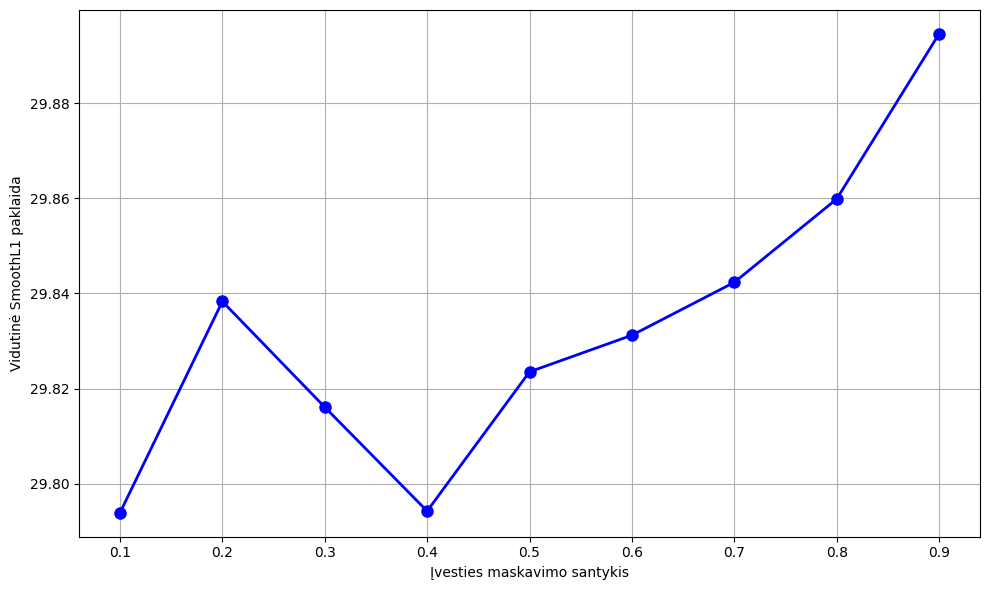

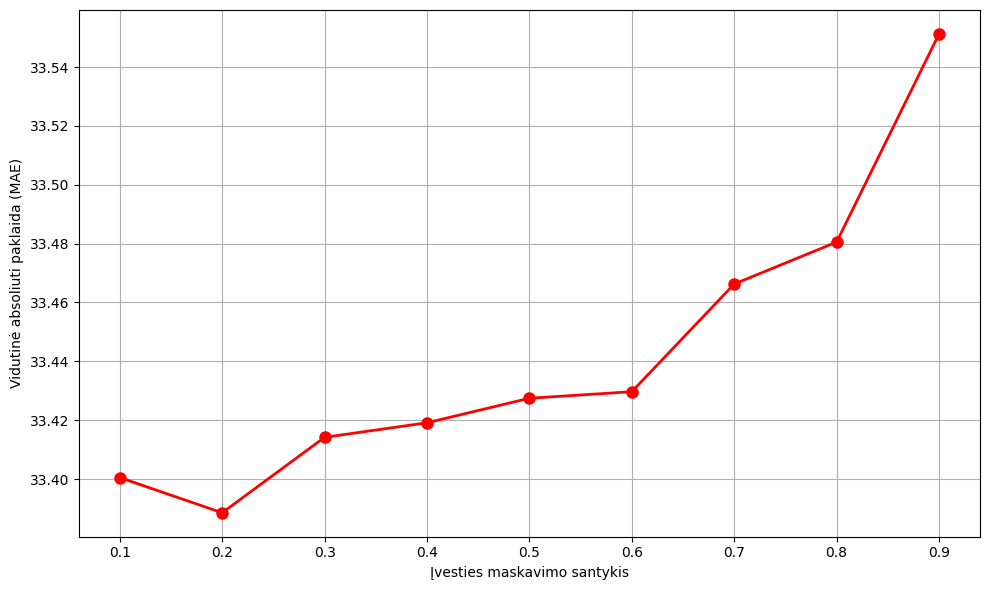

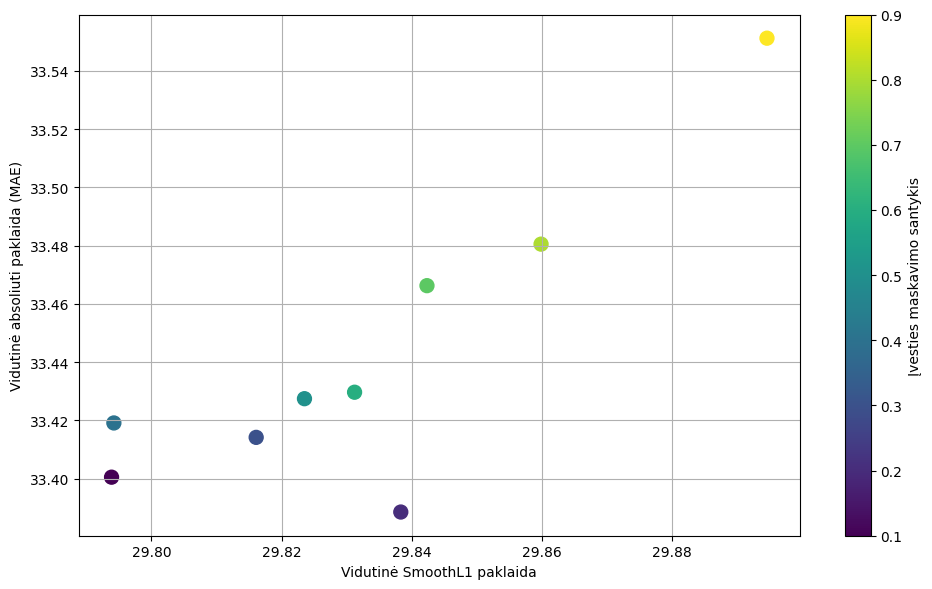

In [101]:
mean, std = sensor_data_matrix.mean(), sensor_data_matrix.std()

l1_scores_unnormalized = [score * std + mean for score in l1_scores]
mae_scores_unnormalized = [score * std + mean for score in mae_scores]

plot_smooth_l1_vs_mask_ratio(mask_ratios_plot_vals, l1_scores_unnormalized)
plot_mae_vs_mask_ratio(mask_ratios_plot_vals, mae_scores_unnormalized)
plot_smooth_l1_vs_mae_colored(l1_scores_unnormalized, mae_scores_unnormalized, mask_ratios_plot_vals)

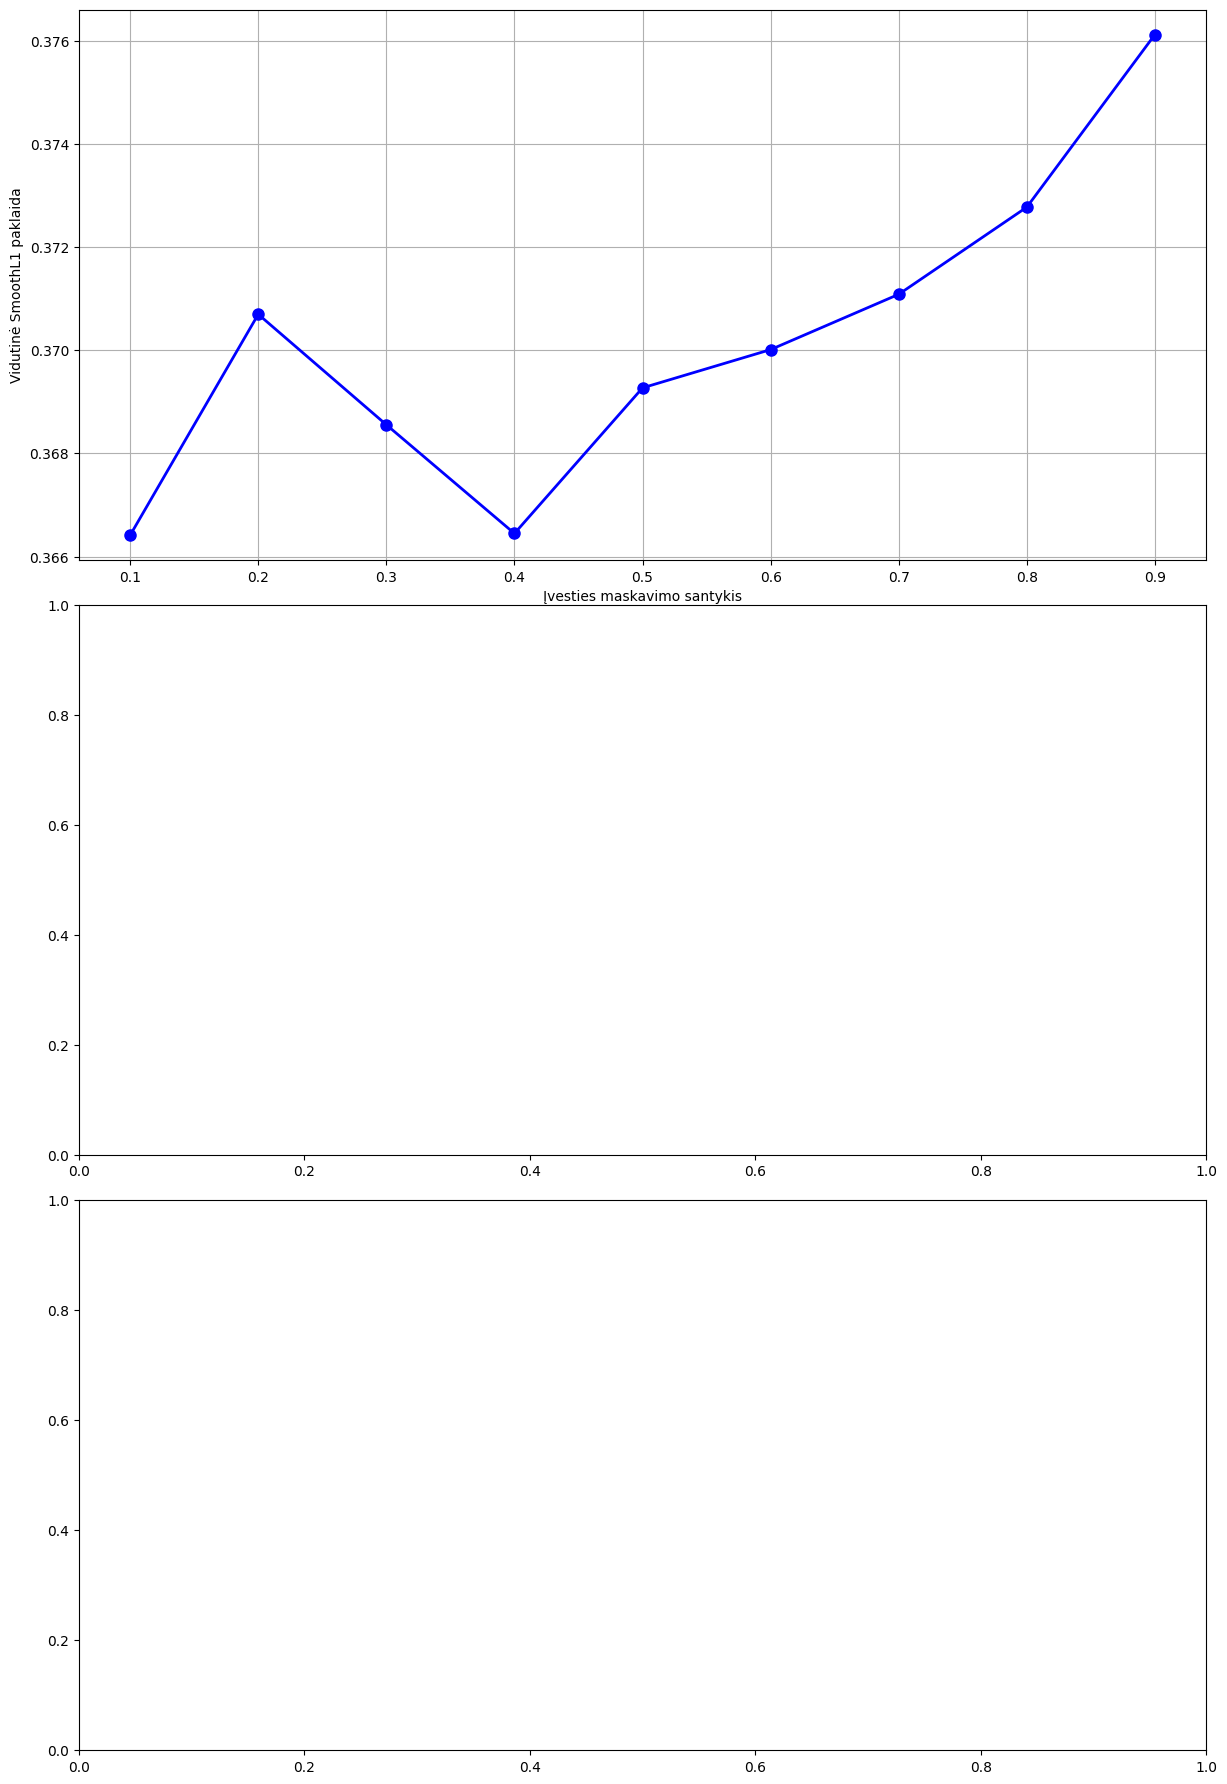


Detailed Statistics:
SmoothL1 Loss range: 0.3664 to 0.3761
MAE range: 0.7129 to 0.7286
SmoothL1 Loss-MAE correlation: 0.8499
Mask Ratio-SmoothL1 Loss correlation: 0.8018
Mask Ratio-MAE correlation: 0.9015


In [42]:
plot_mask_ratios(mask_ratios_plot_vals, l1_scores, mae_scores)

In [ ]:
G_roads = load_file('/content/road_graph.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/content/road_graph.pkl'

In [ ]:
def get_all_road_nodes(road_graph):
    """
    Extract all nodes from the road network
    Returns:
        all_nodes: List of all node coordinates
        node_mapping: Dictionary mapping node coordinates to node indices
    """
    all_nodes = list(road_graph.nodes())
    node_mapping = {node: idx for idx, node in enumerate(all_nodes)}
    return all_nodes, node_mapping


In [ ]:
def create_road_features_matrix(road_graph, node_mapping):
    """
    Create a matrix of road features for each node using one-hot encoding for categorical variables
    Args:
        road_graph: NetworkX graph of the road network
        node_mapping: Dictionary mapping node coordinates to indices
    Returns:
        road_features: Matrix of road features [num_nodes, num_features]
    """
    # Define categorical mappings
    kategor_mapping = {
        '1': 0,  # Autostrados
        '2': 1,  # Magistraliniai keliai
        '3': 2,  # Krašto keliai
        '4': 3,  # Rajoniniai keliai
        '5': 4,  # Jungiamieji keliai
        '6': 5,  # Vietiniai keliai
        '7': 6,  # Pagrindinės gatvės
        '8': 7,  # Jungiamosios gatvės
        '9': 8,  # Kitos gatvės
        '10': 9,  # Įvažiavimai į kiemus
        '11': 10,  # Pėsčiųjų gatvės
        '12': 11,  # Pėsčiųjų takai
        '13': 12,  # Aikštės
        '14': 13   # Lėktuvų pakilimo takai
    }

    oneway_mapping = {
        'F': 0,  # Vienpusis eismas
        'N': 1,  # Blokuotas eismas
        None: 2  # Default/empty
    }

    danga_mapping = {
        'A': 0,  # Asfaltas, asfaltbetonis
        'C': 1,  # Cementbetonis
        'G': 2,  # Gruntas
        'Z': 3,  # Žvyras
        'N': 4   # Neapibrėžta
    }

    num_nodes = len(node_mapping)
    # Total features: 14 kategor + 3 oneway + 5 danga = 22 features
    num_features = len(kategor_mapping) + len(oneway_mapping) + len(danga_mapping)
    road_features = np.zeros((num_nodes, num_features))

    print("\nProcessing road features for nodes:")
    for node, idx in node_mapping.items():
        # Get all edges connected to this node
        edges = list(road_graph.edges(node, data=True))
        if edges:
            # Initialize feature counters for this node
            kategor_counts = np.zeros(len(kategor_mapping))
            oneway_counts = np.zeros(len(oneway_mapping))
            danga_counts = np.zeros(len(danga_mapping))

            for _, _, data in edges:
                # Get and map kategor
                kategor = str(data.get('kategor', '9'))  # Default to '9' if missing
                if kategor in kategor_mapping:
                    kategor_counts[kategor_mapping[kategor]] += 1

                # Get and map oneway
                oneway = data.get('oneway')
                if oneway in oneway_mapping:
                    oneway_counts[oneway_mapping[oneway]] += 1
                else:
                    oneway_counts[oneway_mapping[None]] += 1

                # Get and map danga
                danga = data.get('danga')
                if danga in danga_mapping:
                    danga_counts[danga_mapping[danga]] += 1
                else:
                    danga_counts[danga_mapping['N']] += 1

            # Normalize counts to get probabilities
            if np.sum(kategor_counts) > 0:
                kategor_counts = kategor_counts / np.sum(kategor_counts)
            if np.sum(oneway_counts) > 0:
                oneway_counts = oneway_counts / np.sum(oneway_counts)
            if np.sum(danga_counts) > 0:
                danga_counts = danga_counts / np.sum(danga_counts)

            # Combine all features
            road_features[idx] = np.concatenate([kategor_counts, oneway_counts, danga_counts])

            if idx < 5:  # Print features for first few nodes
                print(f"\nNode {node}:")
                print(f"  Number of connected edges: {len(edges)}")
                print("  Kategor distribution:", kategor_counts)
                print("  Oneway distribution:", oneway_counts)
                print("  Danga distribution:", danga_counts)

    # Print summary statistics
    print("\nRoad features summary:")
    print("Number of nodes with non-zero features:", np.sum(np.any(road_features != 0, axis=1)))
    print("Feature means:", np.mean(road_features, axis=0))
    print("Feature stds:", np.std(road_features, axis=0))

    return road_features

In [ ]:
def create_enhanced_adjacency_matrix(distance_matrix, road_features, distance_threshold=0.1, feature_weights=None):
    """
    Create adjacency matrix incorporating both distance and road features
    Args:
        distance_matrix: Distance matrix [num_nodes, num_nodes]
        road_features: Road features matrix [num_nodes, num_features]
        distance_threshold: Distance threshold for creating edges
        feature_weights: Weights for each road feature (default: equal weights)
    Returns:
        adj_matrix: Enhanced adjacency matrix
    """
    if feature_weights is None:
        feature_weights = np.ones(road_features.shape[1]) / road_features.shape[1]

    # Create base adjacency matrix based on distance threshold
    adj_matrix = (distance_matrix > 0) & (distance_matrix <= distance_threshold)

    # Compute feature similarity matrix
    feature_similarity = np.zeros_like(distance_matrix)
    for i in range(len(road_features)):
        for j in range(len(road_features)):
            if adj_matrix[i, j]:
                # Compute weighted feature similarity
                feature_diff = np.abs(road_features[i] - road_features[j])
                similarity = np.exp(-np.sum(feature_weights * feature_diff))
                feature_similarity[i, j] = similarity

    # Combine distance and feature similarity
    distance_weight = 0.7  # Weight for distance component
    feature_weight = 0.3   # Weight for feature similarity component

    # Normalize distance matrix
    norm_distance = distance_matrix / distance_matrix.max()

    # Create final adjacency matrix
    enhanced_adj = adj_matrix * (
        distance_weight * (1 - norm_distance) +  # Closer nodes get higher weight
        feature_weight * feature_similarity      # Similar features get higher weight
    )

    return enhanced_adj


In [ ]:
def euclidean_distance(x1, y1, x2, y2):
    """
    Calculate Euclidean distance between two points in EPSG:3346 coordinates
    Args:
        x1, y1: Coordinates of first point in EPSG:3346
        x2, y2: Coordinates of second point in EPSG:3346
    Returns:
        distance: Distance in meters
    """
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [ ]:
road_data = load_road_data('../data/road_data/keliai_gatves_ExportFeatures1.shp')

In [ ]:
def get_road_graph(road_data):
    G_roads = nx.Graph()

    for _, row in road_data.iterrows():
        line = row.geometry  # Get the LINESTRING geometry
        coords = list(line.coords)  # Extract coordinates as a list of (x, y) tuples
        for i in range(len(coords) - 1):
            start = coords[i]  # Start point of the segment
            end = coords[i + 1]  # End point of the segment
            length = LineString([start, end]).length  # Length of the segment
            G_roads.add_edge(start, end,
                           weight=length,
                           danga=row.get('danga', 0),
                           oneway=row.get('oneway', 0),
                           kategor=row.get('kategor', 0))  # Add edge with weight and road attributes

    return G_roads

In [ ]:
G_roads = get_road_graph(road_data)

In [ ]:
# Get a sample of edge attributes from G_roads
sample_edges = list(G_roads.edges(data=True))[:5]  # Get first 5 edges with their attributes
for edge in sample_edges:
    start, end, attrs = edge
    print(f"Edge from {start} to {end}:")
    print(f"Attributes: {attrs}\n")


Edge from (584902.2800221723, 6076630.778010681) to (584929.0609900979, 6076636.534015218):
Attributes: {'weight': 27.39255065269633, 'danga': 'Z', 'oneway': None, 'kategor': 9.0}

Edge from (584902.2800221723, 6076630.778010681) to (584900.9839884322, 6076638.967120945):
Attributes: {'weight': 8.291033130693906, 'danga': 'Z', 'oneway': None, 'kategor': 8.0}

Edge from (584902.2800221723, 6076630.778010681) to (584908.0119153019, 6076594.539115416):
Attributes: {'weight': 36.68940077059412, 'danga': 'Z', 'oneway': None, 'kategor': 8.0}

Edge from (584929.0609900979, 6076636.534015218) to (585068.650002365, 6076694.213978289):
Attributes: {'weight': 151.03665278850684, 'danga': 'Z', 'oneway': None, 'kategor': 9.0}

Edge from (584900.9839884322, 6076638.967120945) to (584888.0489040846, 6076692.393886793):
Attributes: {'weight': 54.970316681384226, 'danga': 'Z', 'oneway': None, 'kategor': 8.0}



In [ ]:
# G_roads = load_file('/content/road_graph.pkl')
gdf_sensors = load_file('../data/exported_data/sensor_geo_data.pkl')

In [ ]:
gdf_nearest = gpd.sjoin_nearest(gdf_sensors, road_data, how='left', distance_col='distance')

In [ ]:
all_graph_nodes = sorted(list(G_roads.nodes()))

In [ ]:
num_nodes = len(all_graph_nodes)
node_mapping = {node_id: i for i, node_id in enumerate(all_graph_nodes)}
inverse_node_mapping = {i: node_id for node_id, i in node_mapping.items()}
num_nodes = len(all_graph_nodes)

In [ ]:
source_nodes_idx = []
target_nodes_idx = []
edge_weights_list = []

for u_orig, v_orig, data in G_roads.edges(data=True):
    if u_orig not in node_mapping or v_orig not in node_mapping:
        # print(f"Warning: Edge ({u_orig}, {v_orig}) contains nodes not in node_mapping. Skipping this edge.")
        continue
    u_idx = node_mapping[u_orig]
    v_idx = node_mapping[v_orig]

    source_nodes_idx.append(u_idx)
    target_nodes_idx.append(v_idx)
    edge_weights_list.append(data.get('weight', 1.0))
    # Add reverse if needed for your model/GCN layer specifics
    # source_nodes_idx.append(v_idx)
    # target_nodes_idx.append(u_idx)
    # edge_weights_list.append(data.get('weight', 1.0))


if not source_nodes_idx:
     print("Warning: No edges processed. Edge index will be empty.")
     edge_index = torch.empty((2,0), dtype=torch.long)
     edge_attr = torch.empty((0,), dtype=torch.float)
else:
    edge_index = torch.tensor([source_nodes_idx, target_nodes_idx], dtype=torch.long)
    edge_attr = torch.tensor(edge_weights_list, dtype=torch.float)

print(f"Edge index shape: {edge_index.shape}")
print(f"Edge attributes (weights) shape: {edge_attr.shape}")

NameError: name 'torch' is not defined

In [ ]:
original_sensor_node_ids_from_gdf = gdf_nearest.index.tolist()
mapped_sensor_indices_list = []
for orig_id in original_sensor_node_ids_from_gdf:
    if orig_id in node_mapping:
        mapped_sensor_indices_list.append(node_mapping[orig_id])
    else:
        print(f"Warning: Node ID '{orig_id}' from gdf_nearest.index not found in node_mapping. Skipping.")

sensor_indices_for_mask = torch.tensor(mapped_sensor_indices_list, dtype=torch.long)

if sensor_indices_for_mask.numel() == 0 and num_nodes > 0:
    print("CRITICAL WARNING: No sensor indices were derived from gdf_nearest.index after mapping. "
          "The input mask will likely be all zeros, meaning the model may not have effective input.")
elif num_nodes > 0 :
     print(f"Derived {sensor_indices_for_mask.numel()} sensor indices for masking from gdf_nearest.index.")

In [ ]:
# interpolation

x_input_speeds = torch.zeros((1, num_nodes, sequence_len), dtype=torch.float)

#fill the non zero values

In [ ]:
def create_full_network_mask_corrected(self_model, x_input_tensor, current_sensor_indices_tensor):
    mask = torch.zeros_like(x_input_tensor, device=x_input_tensor.device)
    if current_sensor_indices_tensor.numel() > 0:
        mask[:, current_sensor_indices_tensor, :] = 1
    return mask

if hasattr(model, 'create_full_network_mask'):
    model.create_full_network_mask = create_full_network_mask_corrected.__get__(model, type(model))
    print("Applied corrected create_full_network_mask to the model instance.")
else:
    print("Warning: create_full_network_mask method not found on model instance.")
print("Model loaded and configured.")

In [ ]:
x_input_speeds = x_input_speeds.to(device)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
sensor_indices_for_mask = sensor_indices_for_mask.to(device) # Use the one from gdf_nearest

In [ ]:
if num_nodes == 0:
    print("Cannot perform prediction as there are no nodes in the graph.")
    mean_predictions = torch.empty(0) # Assign a default empty tensor
elif sensor_indices_for_mask.numel() == 0:
    print("Warning: No sensor indices to use for prediction input. Model output might be all zeros or based on unconditional learned biases.")
    # Decide how to proceed: maybe run with empty sensor_indices, or skip.
    # Running with empty sensor_indices means masked_x will be all zeros.
    with torch.no_grad():
        mean_predictions, mask_used, pi_pred, n_pred, p_pred = model(
            x=x_input_speeds, # Will be all zeros if sensor_indices is empty and x_input_speeds was not otherwise populated
            edge_index=edge_index,
            edge_weight=edge_attr,
            sensor_indices=sensor_indices_for_mask, # Empty tensor
            is_full_network=True
        )
else:
    with torch.no_grad():
        mean_predictions, mask_used, pi_pred, n_pred, p_pred = model(
            x=x_input_speeds,
            edge_index=edge_index,
            edge_weight=edge_attr,
            sensor_indices=sensor_indices_for_mask, # Key change: using indices from gdf_nearest
            is_full_network=True
        )
if num_nodes > 0 :
 print(f"Shape of raw mean_predictions: {mean_predictions.shape if mean_predictions.numel() > 0 else 'Empty'}")

In [ ]:
model.eval()

y_preds = list()
y_true = list()

for x, y in test_loader:
  y = y.cpu().numpy().reshape(-1)
  y = inverse_zscore(y, sensor_data_matrix.mean(), sensor_data_matrix.std())

  y_pred = model(x, edge_index).view(len(x), -1).cpu().detach().numpy().reshape(-1)
  y_pred = inverse_zscore(y_pred, sensor_data_matrix.mean(), sensor_data_matrix.std())

  y_preds.extend(list(y_pred))
  y_true.extend(list(y))

y_preds = np.array(y_preds)
y_true = np.array(y_true)

y_preds = y_preds.reshape(int(y_preds.shape[0]/(232 * 6)), 232, 6)
y_true = y_true.reshape(int(y_true.shape[0]/(232 * 6)), 232, 6)

NameError: name 'model' is not defined

In [ ]:
y_preds.shape, y_true.shape

((1696, 232, 6), (1696, 232, 6))

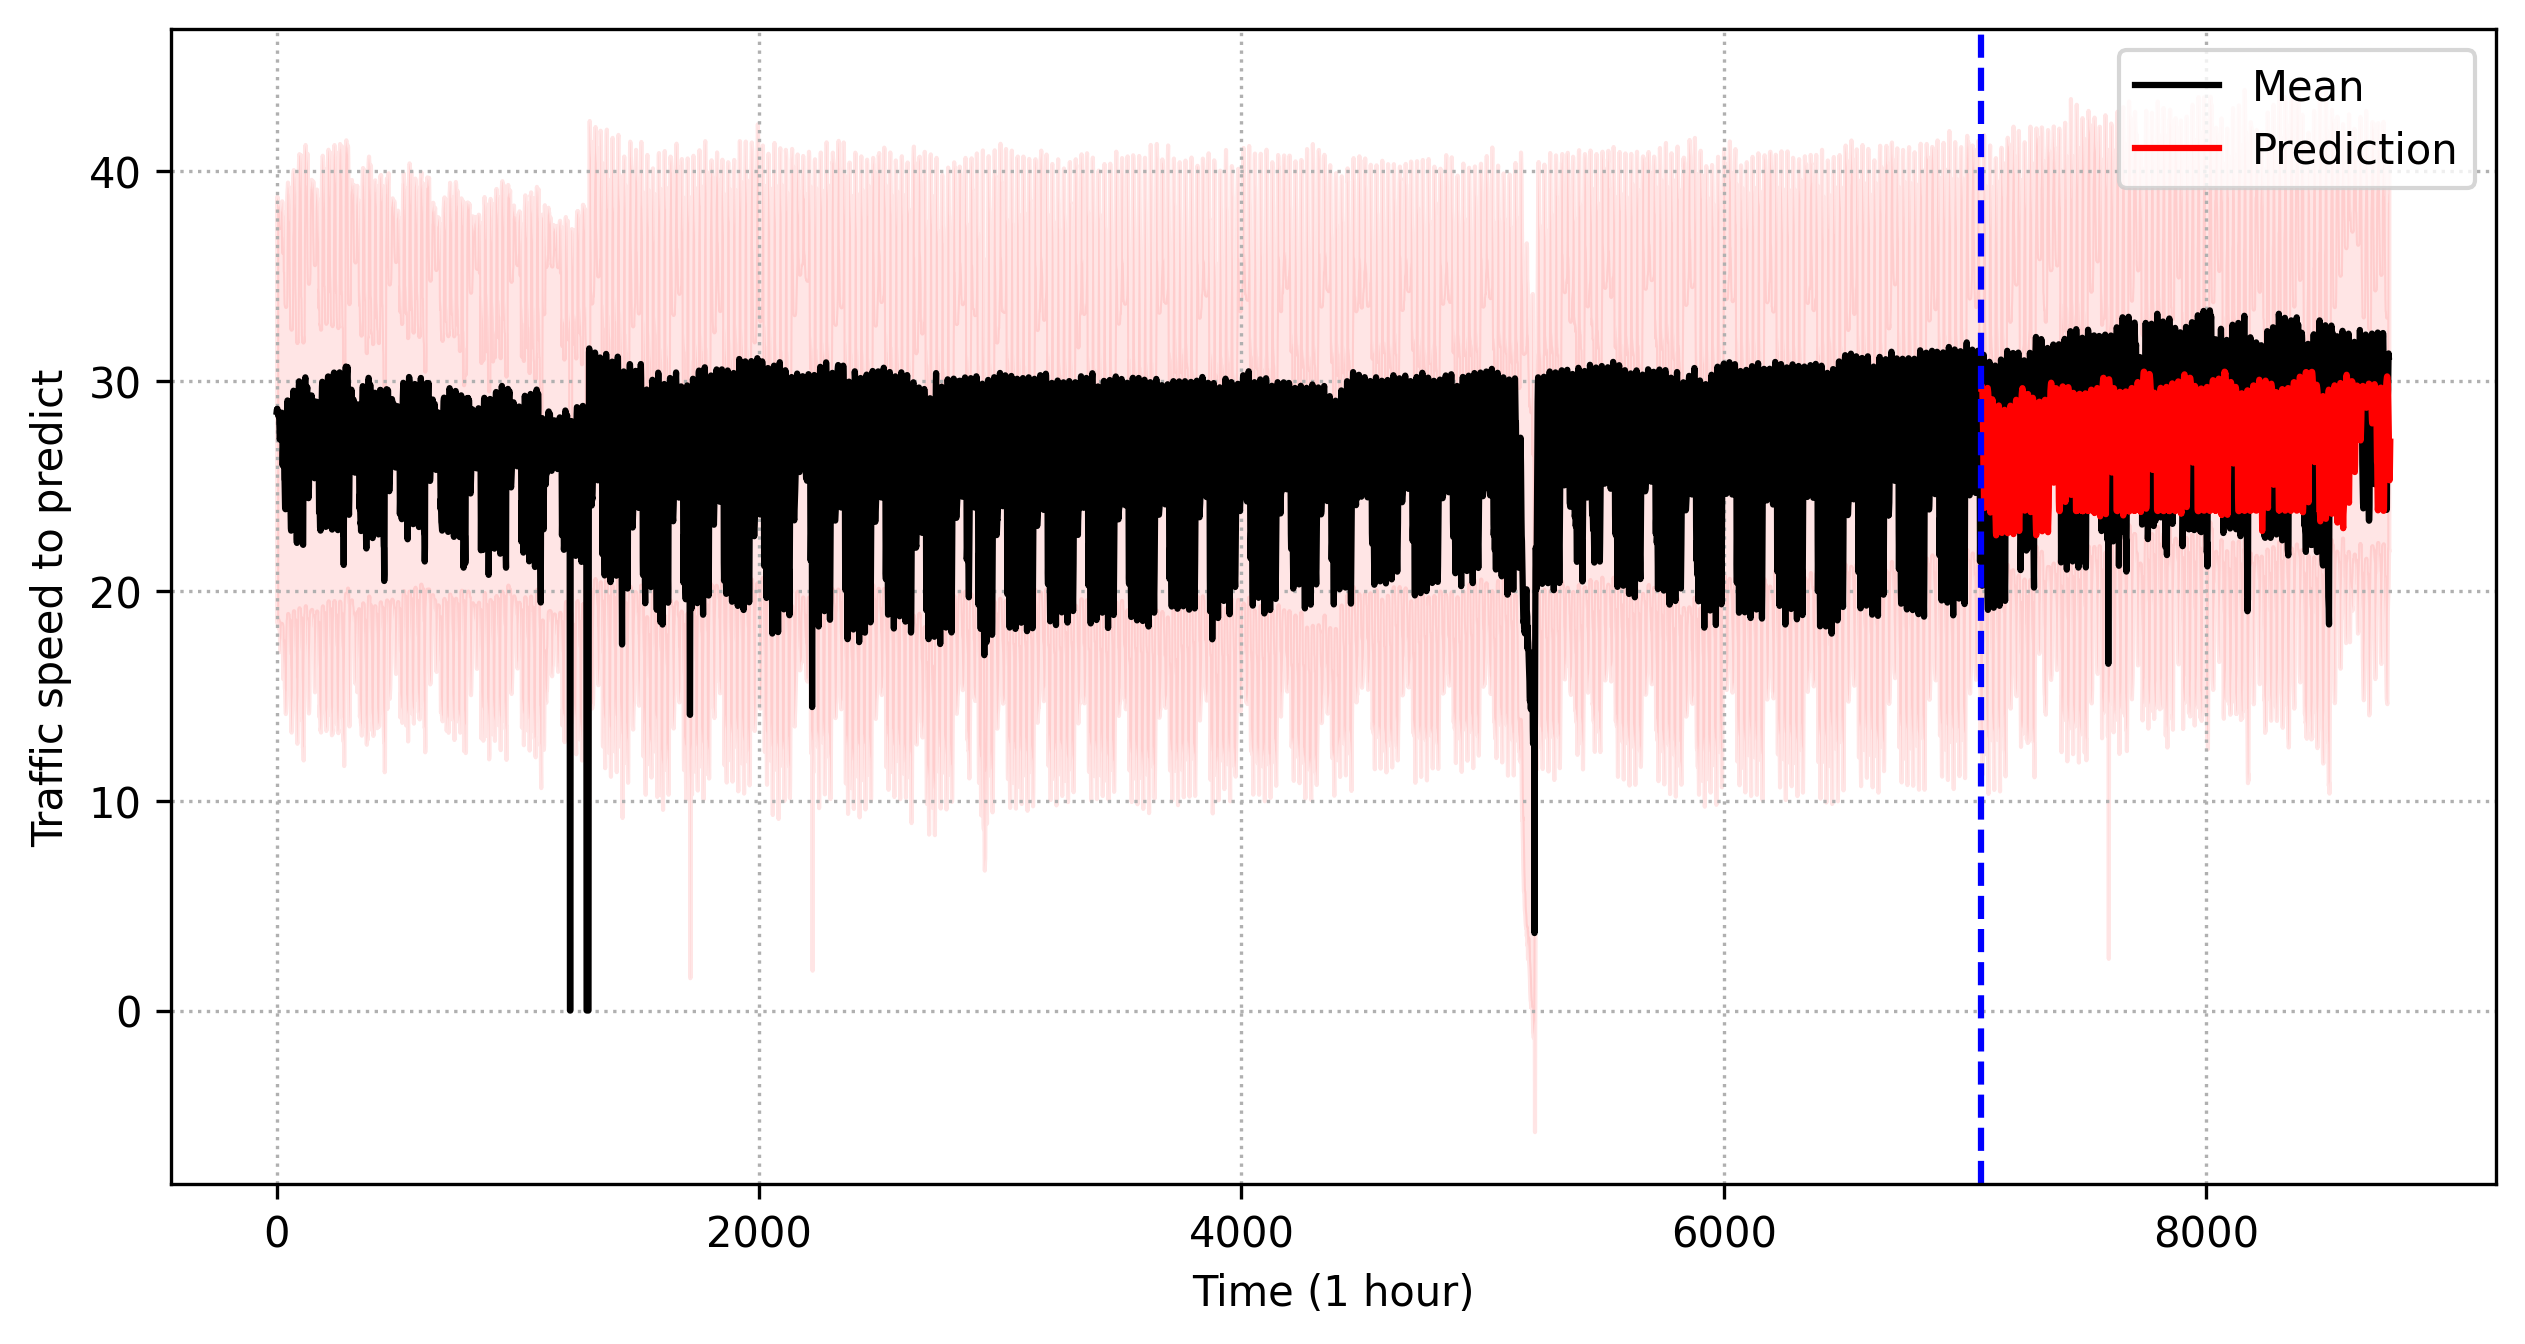

In [ ]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(mean_speeds, 'k-', label='Mean')

pred_start = len(sensor_data_matrix) - len(y_preds) + 6

plt.plot(range(pred_start, pred_start + len(y_preds)), y_preds[:, :, 5].mean(axis=1), 'r-', label='Prediction')

plt.grid(linestyle=':')
plt.fill_between(np.arange(sensor_data_matrix.shape[0]), mean_speeds - std, mean_speeds + std, color='r', alpha=0.1)

plt.axvline(x=pred_start, color='b', linestyle='--')

plt.xlabel('Time (1 hour)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  1e-18 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  9.658814321219602
MAE:  7.442094326019287
MAPE:  5.711697692065792e+17 %


In [ ]:
PATH = "epoch_30_model_no_batches.pt"

torch.save(model.state_dict(), PATH)
